## Question 2 - Bengio Model Update Training Model


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import random
import math
import time
import pickle
import matplotlib.pyplot as plt

***Set Parameters***

In [0]:
class Model(object):
    def __init__(self, params):
       
        #x,y
        self._x = tf.placeholder(dtype=tf.int32, shape=(params.batch_size, params.window_size-1))
        self._y = tf.placeholder(dtype=tf.int32, shape=(params.batch_size, 1))

        # C
        self.C = tf.Variable(tf.truncated_normal(shape=(params.vocab_size, params.embeddings_dim), mean=-1, stddev=-1), name='word_embedding')

        # Hidden Layer Weight && Bias
        self.H = tf.Variable(tf.random_normal(shape=(params.hidden_units, (params.window_size - 1 ) * params.embeddings_dim)))
        self.d = tf.Variable(tf.random_normal(shape=(params.hidden_units, )))

        # Hidden-to-Output Weight && Bias
        self.U = tf.Variable(tf.random_normal(shape=(params.vocab_size, params.hidden_units)))
        self.b = tf.Variable(tf.random_normal(shape=(params.vocab_size, )))

        # Projection-to-Output Weight
        self.W = tf.Variable(tf.random_normal(shape=(params.vocab_size, (params.window_size - 1) * params.embeddings_dim)))

        #completed layout


        ###### y = b + Wx + Utanh(d + Hx) #####

        # x = (C(w(t-1)), C(w(t-2), ..., C(w(t-n+1))), n == window_size
        with tf.name_scope('Projection_Layer'):
            x  = tf.nn.embedding_lookup(self.C, self._x) # (batch_size, window_size-1, emb_dim)
            x  = tf.reshape(x, shape=(params.batch_size, (params.window_size - 1) * params.embeddings_dim))

        with tf.name_scope('Hidden_Layer'):
            Hx = tf.matmul(x, tf.transpose(self.H)) # (batch_size, hidden_size)
            o  = tf.add(self.d, Hx) # (batch_size, hidden_size)
            a  = tf.nn.tanh(o)  # (batch_size, hidden_size)
            
        with tf.name_scope('Output_Layer'):
            Ua = tf.matmul(a, tf.transpose(self.U)) # (batch_size, vocab_size)
            Wx = tf.matmul(x, tf.transpose(self.W)) # (batch_size, vocab_size)
            y_hat  = tf.nn.softmax(tf.clip_by_value(tf.add(self.b, tf.add(Wx, Ua)), 0.0, 10)) # (batch_size, vocab_size)
            

        with tf.name_scope('Loss'):
            onehot_tgt = tf.one_hot(tf.squeeze(self._y), params.vocab_size)  # (batch_size, vocab_size)
            self.loss = -1 * tf.reduce_mean(tf.reduce_sum(tf.log(y_hat) * onehot_tgt, 1)) # 乘 -1 -> maximize loss
            self.perplexity = tf.exp(self.loss)
        self.optimizer = tf.train.AdagradOptimizer(params.learning_rate).minimize(self.loss) 

 

***Helper function to train from batch to batch***

In [0]:

#helper functions for training

#get next batch

def nxt(x_train, y_train, batch_size):
  
    num_batch = 30
    for n in range(num_batch):        
        offset = n * batch_size
        x_batch = x_train[offset: offset + batch_size]
        y_batch = y_train[offset: offset + batch_size]
        
        yield x_batch, y_batch
     

### Train Model
- x and y are set by splitting data before with split helper function
- vocab is a unique vocab list of the corpus
- model tunes for loss

In [0]:
def train(x,y,vocab,params,train_status):
  
    
    epoch_size = params.num_epochs
    batch_size = params.batch_size
    x_train = x
    y_train = y
    if train_status == "true":      
        modl = train_status
    else:
        modl = train_status
    optimizer = modl.optimizer
    loss = modl.loss
    print('Length: {}'.format(len(x_train)))
    print('Number of batch: {}'.format(params.num_batches))
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)    
    lossList = []
    perpList = []
    saver = tf.train.Saver()
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True)) as sess:
        initializer = tf.global_variables_initializer()
        initializer.run()
        
        
        step = 0
        avg_loss = 0
        for epoch in range(epoch_size):
            for x_batch, y_batch in nxt(x_train, y_train, batch_size):
                
                if len(x_batch) != batch_size:
                    print(len(x_batch))
                    print((batch_size))
                   
                    continue
                #train by context windows
                contextCheck = 0
                xContext = []
                yContext = []
                y_batch = np.array(y_batch)
                y_batch.reshape(1,batch_size)
                x_batch = np.array(x_batch)
                x_batch.reshape(batch_size,4)
                y_batch.shape = modl._y.shape
                print(x_batch[:3])
                feed_dict = {modl._x: x_batch, modl._y: y_batch} 
                
                
                loss, perp, ____ = sess.run([modl.loss,modl.perplexity, modl.optimizer], feed_dict = feed_dict)
                #fetches = [loss, modl.optimizer]
                lossList.append(loss)
                perpList.append(perp)
                
                avg_loss += loss
                
                #perplexity_history.append(perplexity)
                #cost_history.append(cost)
                
                step += 1
            lossList.append(np.mean(avg_loss))
            print("loss :" + str(np.mean(avg_loss)))
            avg_loss = 0
                

        print('Training Done.')
        word_embedding = modl.C.eval()
       
        print("---------- Word Embdeddings -------------")
        # print(word_embedding)
        
        
        #sess.run(tf.global_variables_initializer())
        
        # Save the variables to disk.
        #save_path = saver.save(sess, "/tmp/model2.ckpt")
        #print("Model saved in path: %s" % save_path)
        return lossList,perpList,word_embedding,modl
        

***Open unbated brown data and turn into array of integers like previous corpus***

### News Data on trained brown corpus

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


***load + process data***

In [0]:
#load pickle files
fileSetTrain = open('/content/drive/My Drive/Colab Notebooks/newsData/trainingSetPickle.pkl','rb')
vocab_dictSetNewsT = pickle.load(fileSetTrain)
fileSetValid = open('/content/drive/My Drive/Colab Notebooks/newsData/validationSetPickle.pkl','rb')
vocab_dictSetNewsV = pickle.load(fileSetValid)
fileSetTest = open('/content/drive/My Drive/Colab Notebooks/newsData/testingSetPickle.pkl','rb')
vocab_dictSetNewsTest = pickle.load(fileSetTest)

In [8]:
def makeMatrix(vocab,window_size):
    x_train, y_train = [], []
    for i in range(len(vocab) - window_size + 1):
        x_train.append(vocab[i: i + window_size - 1])
        y_train.append(vocab[i +  window_size - 1])
    return x_train,y_train
x_trainNewsT,y_trainNewsT = makeMatrix(vocab_dictSetNewsT,5)
x_validNewsV,y_validNewsV = makeMatrix(vocab_dictSetNewsV,5)
x_testNewsTest,y_testNewsTest = makeMatrix(vocab_dictSetNewsTest,5)
print('vocab_size: {}'.format(len(vocab_dictSetNewsT)))


print('Number of batch: {}'.format(30))

vocab_size: 4694176
Number of batch: 30


***Set Params***

In [0]:
class Parameters():
    def __init__(self,vocabL):
        self.window_size = 5
        self.num_batches = 30

        self.vocab_size = len(vocabL)
        self.batch_size = int(self.vocab_size/self.num_batches)
        self.hidden_units = 50
        self.embeddings_dim = 60
        self.num_epochs = 20

        self.learning_rate = 0.5
        self.context_window = 5
        self.gpu_mem = 0.25

        self.tf_precision = tf.float32
        self.np_precision = np.float32

        self.init_scale = 0.5
        self.max_grad = 10.0
#set params for training
pNewTrain = Parameters(x_trainNewsT[:1000])
pNewTest = Parameters(x_testNewsTest)
pNewValid = Parameters(x_validNewsV)

In [22]:
len(x_trainNewsT)

4694172

***Train Model on Untagged Training Corpus***

**Training corpus**

In [24]:
vDictNewsT = set([token for token in vocab_dictSetNewsT])
lossList,perpList,word_embedding,modl= train(x_trainNewsT[:1000],y_trainNewsT[:1000],vDictNewsT,pNewTrain,Model(pNewTrain))

Length: 1000
Number of batch: 30
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



ResourceExhaustedError: ignored

In [0]:
#perplexity graph for untagged training
pListT = []
lListT = []
epochT = []
for x in range(pNewTrain.num_batches):
    i = x * 30
    pListT.append(np.mean(perpList[i: i + 30]))
    lListT.append(np.mean(lossList[i: i + 30]))
    epochT.append(x)
    
plt.plot(epochT,pListT)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

ValueError: No variables to save

In [0]:
#loss plot for untagged training
plt.plot(epochT,lListT)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

hello


***validation corpus***

In [0]:
vDictNewsV = set([token for token in vocab_dictSetNewsV])
lossListV,perpListV,word_embeddingV,modlV= train(x_validNewsV,y_validNewsV,vDictNewsV,pNewValid,modl)

Length: 5
Number of batch: 30
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

5
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
loss :0.0
5
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
loss :0.0
5
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
loss :0.0
5
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
0
8321
loss :0.

In [0]:
#perplexity graph for untagged validation
pListV = []
lListV = []
epochV = []
for x in range(pNewValid.num_batches):
    i = x * 30
    pListV.append(np.mean(perpListV[i: i + 30]))
    lListV.append(np.mean(lossListV[i: i + 30]))
    epochV.append(x)
    
plt.plot(epochV,pListV)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

In [0]:
#loss plot for untagged validation
plt.plot(epochV,lListV)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

***Testing Corpus***

In [0]:
vDictNewsTest = set([token for token in vocab_dictSetNewsTest])
x_testNewsTest[x_testNewsTest == '<unk>'] = '8888888888'
y_testNewsTest[y_testNewsTest == '<unk>'] = '8888888888'
lossListTest,perpListTest,word_embeddingTest,modlTest= train(x_testNewsTest,y_testNewsTest,vDictNewsTest,pNewTest,modl)



Length: 998232
Number of batch: 30
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



KeyboardInterrupt: 

/Users/siyabongamatchaba/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/siyabongamatchaba/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


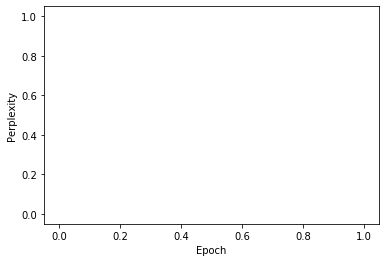

In [0]:
#perplexity graph for untagged testing
pListTest = []
lListTest = []
epochTest = []
for x in range(pNewTest.num_batches):
    i = x * 30
    pListV.append(np.mean(perpListTest[i: i + 30]))
    lListV.append(np.mean(lossListTest[i: i + 30]))
    epochV.append(x)
    
plt.plot(epochTest,pListTest)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

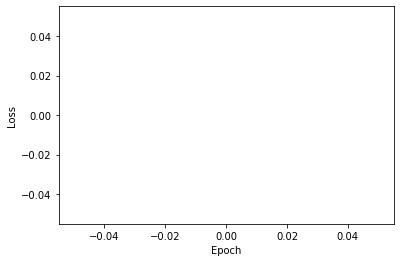

In [0]:
#loss plot for untagged testing
plt.plot(epochTest,lListTest)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Question 5

In [0]:
class ModelExperiment(object):
    def __init__(self, params):
       
        #x,y
        self._x = tf.placeholder(dtype=tf.int32, shape=(params.batch_size, params.window_size-1))
        self._y = tf.placeholder(dtype=tf.int32, shape=(params.batch_size, 1))

        # C
        self.C = tf.Variable(tf.truncated_normal(shape=(params.vocab_size, params.embeddings_dim), mean=-1, stddev=-1), name='word_embedding')

        # Hidden Layer Weight && Bias
        self.H = tf.Variable(tf.random_normal(shape=(params.hidden_units, (params.window_size - 1 ) * params.embeddings_dim)))
        self.d = tf.Variable(tf.random_normal(shape=(params.hidden_units, )))

        # Hidden-to-Output Weight && Bias
        self.U = tf.Variable(tf.random_normal(shape=(params.vocab_size, params.hidden_units)))
        self.b = tf.Variable(tf.random_normal(shape=(params.vocab_size, )))

        # Projection-to-Output Weight
        self.W = tf.Variable(tf.random_normal(shape=(params.vocab_size, (params.window_size - 1) * params.embeddings_dim)))

        #completed layout


        ###### y = b + Wx + Utanh(d + Hx) #####

        # x = (C(w(t-1)), C(w(t-2), ..., C(w(t-n+1))), n == window_size
        with tf.name_scope('Projection_Layer'):
            x  = tf.nn.embedding_lookup(self.C, self._x) # (batch_size, window_size-1, emb_dim)
            x  = tf.reshape(x, shape=(params.batch_size, (params.window_size - 1) * params.embeddings_dim))

        with tf.name_scope('Hidden_Layer'):
            Hx = tf.matmul(x, tf.transpose(self.H)) # (batch_size, hidden_size)
            o  = tf.add(self.d, Hx) # (batch_size, hidden_size)
            a  = tf.nn.tanh(o)  # (batch_size, hidden_size)
            
        with tf.name_scope('Output_Layer'):
            Ua = tf.matmul(a, tf.transpose(self.U)) # (batch_size, vocab_size)
            Wx = tf.matmul(x, tf.transpose(self.W)) # (batch_size, vocab_size)
            y_hat  = tf.nn.softmax(tf.clip_by_value(tf.add(self.b, tf.add(Wx, Ua)), 0.0, 10)) # (batch_size, vocab_size)
            

        with tf.name_scope('loss'):
            self._y = tf.dtypes.cast(self._y, tf.float32)
            l2_norm = tf.norm((self._y)-y_hat, ord='euclidean')
            self.loss = l2_norm
            self.perplexity = tf.exp(self.loss)
        self.optimizer = tf.train.GradientDescentOptimizer(params.learning_rate).minimize(self.loss)
        
        
       


 

In [0]:
vDictNewsT = set([token for token in vocab_dictSetNewsT])
lossList,perpList,word_embedding,modl= train(x_testNewsTest[:5],y_testNewsTest[:5],vDictNewsTest,pNewTest,ModelExperiment(pNewTrain)
                                            )

Length: 5
Number of batch: 30
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [0]:
#perplexity graph for untagged testing
pList = []
lList = []
epoch = []
for x in range(pNewTest.num_batches):
    i = x * 30
    pList.append(np.mean(perpList[i: i + 30]))
    lList.append(np.mean(lossList[i: i + 30]))
    epoch.append(x)
    
plt.plot(epoch,pList)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

In [0]:
#loss plot for untagged testing
plt.plot(epoch,lList)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()